In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json

2021-09-15 10:56:40.550377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 10:56:40.550442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
path_results = "test_results/20A_20C_15Sept_GPU/" #20A_20C_06Sept_20EPO

In [9]:
def read_json(file_path):
    with open(file_path) as file:
        return json.loads(file.read())

In [10]:
f_dict = read_json(path_results + "f_word_dictionaries.json")
#f_dict

In [11]:
r_dict = read_json(path_results + "r_word_dictionaries.json")
#r_dict

In [12]:
def read_txt(file_path):
    data = None
    with open(file_path) as file:
        data = file.read()
    data = data.split("\n")
    data = data[:len(data) - 1]
    data = [float(i) for i in data]
    return data

In [13]:
tr_gen_true_loss = read_txt(path_results + "tr_gen_true_loss.txt")
tr_gen_fake_loss = read_txt(path_results + "tr_gen_fake_loss.txt")
tr_gen_total_loss = read_txt(path_results + "tr_gen_total_loss.txt")

tr_disc_total_loss = read_txt(path_results + "tr_disc_total_loss.txt")
tr_disc_fake_loss = read_txt(path_results + "tr_disc_fake_loss.txt")
tr_disc_true_loss = read_txt(path_results + "tr_disc_true_loss.txt")
te_loss = read_txt(path_results + "te_loss.txt")
te_loss
n_epochs = len(tr_gen_true_loss)
epochs = np.arange(0, n_epochs)

In [14]:
te_loss

[3.584620714187622,
 4.424239158630371,
 6.617463111877441,
 0.2952830195426941,
 0.009636820293962955,
 0.008924996480345726,
 0.008601713925600052,
 0.008278610184788704,
 0.0079220961779356,
 0.00751928985118866]

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

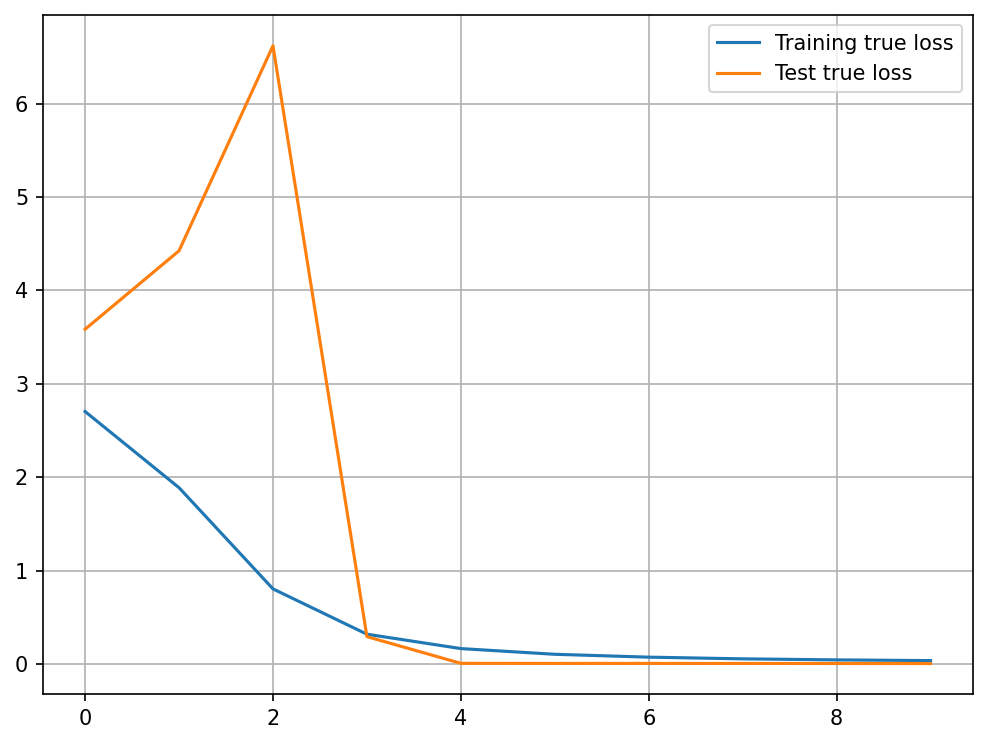

In [16]:
plt.figure(figsize=(8, 6), dpi=150)

plt.plot(epochs, tr_gen_true_loss)
plt.plot(epochs, te_loss)

plt.legend(["Training true loss", "Test true loss"])
plt.grid(True)
plt.show()

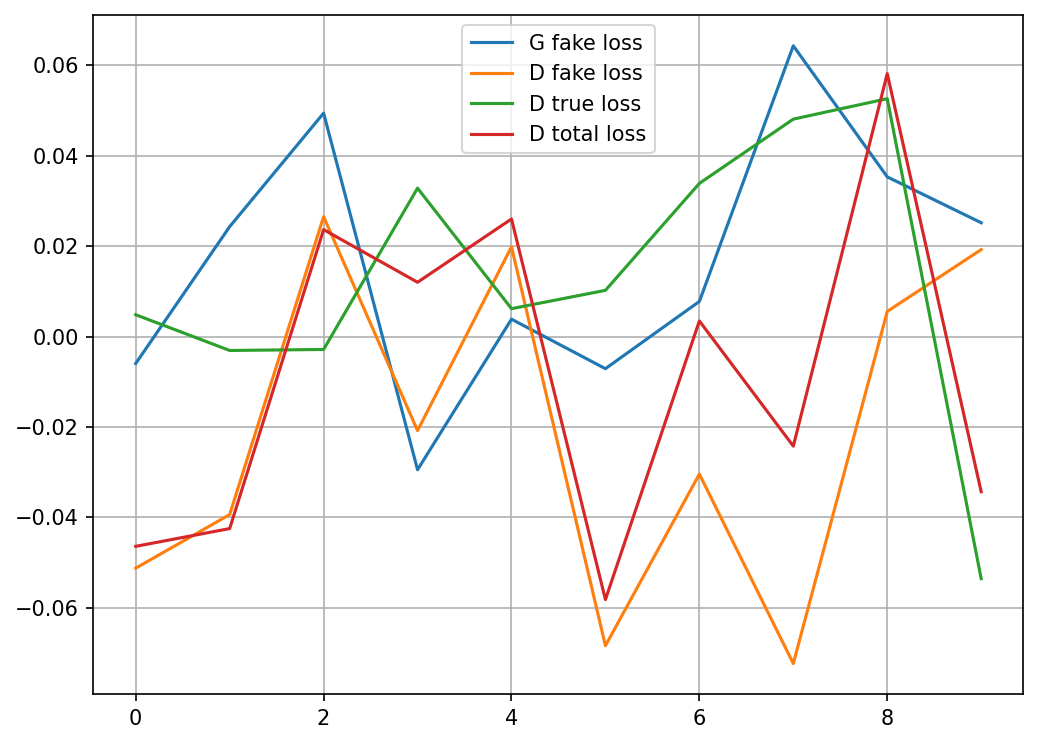

In [17]:
plt.figure(figsize=(8, 6), dpi=150)

plt.plot(epochs, tr_gen_fake_loss)
plt.plot(epochs, tr_disc_fake_loss)
plt.plot(epochs, tr_disc_true_loss)
plt.plot(epochs, tr_disc_total_loss)

plt.legend(["G fake loss", "D fake loss", "D true loss", "D total loss"])
plt.grid(True)
plt.show()

In [421]:
## Mutations from test dataset
df_true_pred = pd.read_csv(path_results + "true_predicted_multiple_te_x_filtered.csv", sep=",")

## Mutations from train dataset
#df_true_pred = pd.read_csv(path_results + "true_predicted_multiple_tr.csv", sep=",")
print(df_true_pred.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'test_results/20A_20C_08Sept/true_predicted_multiple_te_x_filtered.csv'

In [339]:
cols = list(df_true_pred.columns)
max_rows = 5000
#A19_20A = dict()
parent_child = dict()
#A19_C_20A = dict()
parent_gen = dict()
#A20_C_20A = dict()
child_gen = dict()
original_gen = dict()

def write_dict(path, dic):
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    with open(path, "w") as f:
        f.write(json.dumps(dic))
        
def read_wuhan_hu_1_spike():
    wuhan_seq = ""
    path = path_results + "wuhan-hu-1-spike-prot.txt"
    with open(path, "r") as f_seq:
        original_seq = f_seq.read()
    wuhan_seq = original_seq.split("\n")
    wuhan_seq = wuhan_seq[:len(wuhan_seq) - 1]
    wuhan_seq = "".join(wuhan_seq)
    enc_wuhan_seq = [str(r_dict[aa]) for aa in wuhan_seq]
    return ",".join(enc_wuhan_seq)
    

enc_original_wuhan_seq = read_wuhan_hu_1_spike()

original_wuhan = enc_original_wuhan_seq.split(",")

for index, row in df_true_pred.iterrows():
    true_x = row[cols[0]].split(",")
    true_y = row[cols[1]].split(",")
    pred_y = row[cols[2]].split(",")
    
    space = 1
    for i in range(len(true_x)):
        first = true_x[i:i+space]
        sec = true_y[i:i+space]
        third = pred_y[i:i+space]
        orin_wu = original_wuhan[i:i+space]
        first_aa = [f_dict[j] for j in first]
        sec_aa = [f_dict[j] for j in sec]
        third_aa = [f_dict[j] for j in third]
        orin_wu_aa = [f_dict[j] for j in orin_wu]
        
        diff_original_wu_gen = set(third_aa).difference(set(orin_wu_aa))
        intersection_f_s = set(sec_aa).difference(set(first_aa))
        intersection_f_t = set(third_aa).difference(set(first_aa))
        intersection_s_t = set(third_aa).difference(set(sec_aa))
        
        first_mut = first_aa[0]
        second_mut = sec_aa[0]
        third_mut = third_aa[0]
        
        if orin_wu_aa[0] != "X" and third_aa[0] != "X":
            if len(diff_original_wu_gen) > 0:
                key = "{}>{}>{}".format(orin_wu_aa[0], str(i+1), third_aa[0])
                if key not in original_gen:
                    original_gen[key] = 0
                original_gen[key] += 1
        
        if first_mut != "X" and second_mut != "X":

            if len(intersection_f_s) > 0:
                #print("Mutations: parent - child")
                #print(intersection_f_s)
                #print(i+1, first_aa, sec_aa)
                key = "{}>{}>{}".format(first_mut, str(i+1), second_mut)
                #print(key)
                if key not in parent_child:
                    parent_child[key] = 0
                parent_child[key] += 1
                #print("-------------")
        
        if first_mut != "X" and third_mut != "X":
        
            if len(intersection_f_t) > 0:
                #print("Mutations: parent - predicted children of child")
                #print(intersection_f_t)
                #print(i+1, first_aa, third_aa)
                key = "{}>{}>{}".format(first_mut, str(i+1), third_mut)
                #print(key)
                if key not in parent_gen:
                    parent_gen[key] = 0
                parent_gen[key] += 1
                #print("-------------")
        
        if second_mut != "X" and third_mut != "X":
            
            if len(intersection_s_t) > 0:
                #print("Mutations: child - predicted children of child")
                #print(intersection_s_t)
                #print(i+1, sec_aa, third_aa)
                key = "{}>{}>{}".format(second_mut, str(i+1), third_mut)
                #print(key)
                if key not in child_gen:
                    child_gen[key] = 0
                child_gen[key] += 1
                #print("-------------")
                
write_dict(path_results + "parent_child.json", parent_child)
write_dict(path_results + "parent_gen.json", parent_gen)
write_dict(path_results + "child_gen.json", child_gen)
write_dict(path_results + "original_gen.json", original_gen)

In [342]:
parent_child = dict(sorted(parent_child.items(), key=lambda item: item[1], reverse=True))
parent_child, len(parent_child)

({'N>439>K': 980,
  'P>681>R': 610,
  'D>936>Y': 440,
  'R>681>P': 390,
  'S>477>N': 390,
  'V>769>G': 330,
  'V>701>A': 310,
  'V>281>E': 300,
  'K>439>N': 300,
  'F>18>L': 280,
  'Y>138>D': 270,
  'F>98>S': 260,
  'L>5>F': 260,
  'A>522>V': 250,
  'H>681>P': 240,
  'I>20>T': 240,
  'T>572>I': 220,
  'F>6>V': 200,
  'T>20>I': 200,
  'I>76>T': 190,
  'S>771>A': 180,
  'H>251>P': 180,
  'W>152>R': 170,
  'D>215>H': 170,
  'N>501>Y': 170,
  'N>501>T': 170,
  'D>253>G': 170,
  'S>67>A': 170,
  'I>676>T': 160,
  'A>626>S': 160,
  'Q>779>L': 150,
  'G>75>D': 150,
  'R>102>S': 150,
  'A>222>V': 150,
  'S>879>A': 150,
  'V>976>I': 150,
  'V>1078>A': 150,
  'S>27>A': 140,
  'I>68>T': 140,
  'G>1251>V': 140,
  'Q>954>K': 140,
  'S>1078>A': 120,
  'S>459>F': 120,
  'N>477>S': 120,
  'D>1163>Y': 120,
  'I>33>T': 110,
  'T>478>K': 110,
  'I>95>T': 110,
  'H>675>Q': 110,
  'V>1122>L': 110,
  'L>1162>P': 110,
  'T>259>I': 110,
  'L>227>V': 100,
  'I>572>T': 100,
  'M>731>I': 100,
  'L>452>R': 100,
 

In [343]:
parent_gen = dict(sorted(parent_gen.items(), key=lambda item: item[1], reverse=True))
parent_gen, len(parent_gen)

({'R>681>P': 450,
  'K>439>N': 350,
  'V>769>G': 330,
  'V>701>A': 310,
  'V>281>E': 300,
  'F>18>L': 280,
  'Y>138>D': 270,
  'H>681>P': 270,
  'F>98>S': 260,
  'I>20>T': 240,
  'F>6>V': 200,
  'I>76>T': 190,
  'S>771>A': 180,
  'H>251>P': 180,
  'S>67>A': 170,
  'I>676>T': 160,
  'S>879>A': 150,
  'V>1078>A': 150,
  'S>27>A': 140,
  'N>477>S': 140,
  'S>1078>A': 120,
  'I>33>T': 110,
  'I>95>T': 110,
  'H>675>Q': 110,
  'L>1162>P': 110,
  'L>227>V': 100,
  'I>572>T': 100,
  'S>575>A': 100,
  'I>19>T': 100,
  'T>210>I': 90,
  'S>701>A': 90,
  'I>153>M': 90,
  'S>348>A': 90,
  'A>704>S': 90,
  'R>1201>Q': 90,
  'N>558>K': 80,
  'Q>1111>E': 70,
  'F>865>L': 70,
  'S>261>G': 60,
  'R>66>H': 40,
  'K>346>R': 30,
  'H>677>Q': 30,
  'K>478>T': 20,
  'I>716>T': 20},
 44)

In [ ]:
# TODO: Compare parent_child mutations with parent_gen mutations

In [344]:
keys_parent_child = list(parent_child.keys())
keys_parent_gen = list(parent_gen.keys())
keys_child_gen = list(child_gen.keys())

In [349]:
mut_parent_gen_parent_child = list(set(keys_parent_gen).difference(list(set(keys_parent_child))))
mut_parent_gen_parent_child

[]

In [350]:
mut_child_gen_parent_child = list(set(keys_child_gen).difference(list(set(keys_parent_child))))

In [324]:
import pandas as pd

#c_20A = ["20B", "20C", "20E (EU1)", "21A (Delta)", "21B (Kappa)", "21D (Eta)"]
c_20C = ["20C"]

#c_20C = ["20H (Beta, V2)", "20G" ,"21C (Epsilon)", "21F (Iota)"]

df = pd.read_csv("data/generated_files/sample_clade_mutation.csv", sep=",")

c_mut_list = list()

for c in c_20C:
    u_list = list()
    df_mut = df[df["Nextstrain clades"] == c]["Mutations"]
    df_mut_list = df_mut.tolist()
    for item in df_mut_list:
        mut = item.split(",")
        u_list.extend(mut)
    u_list = list(set(u_list))
    c_mut_list.extend(u_list)

In [325]:
print(c_mut_list)

['S155R', 'L1063F', 'A570V', 'D867A', 'Q675R', 'H69Y', 'S297T', 'A626S', 'T676A', 'T478R', 'M731I', 'W152R', 'P26L', 'V407I', 'Q954K', 'G261V', 'P1162S', 'Q779L', 'D936Y', 'D1163Y', 'I68T', 'D215H', 'V1228L', 'T250I', 'N501Y', 'V308L', 'T791I', 'V976I', 'L452R', 'P631S', 'T20I', 'H950D', 'L5F', 'E654Q', 'R452L', 'N1187Y', 'T95I']


In [326]:
len(list(set(parent_gen)))

44

In [329]:
print(parent_gen)
for novel_mut in parent_gen:
    par, mut_pos, cld = novel_mut.split(">")[0], novel_mut.split(">")[1], novel_mut.split(">")[2]
    n_mut = "{}{}{}".format(par, mut_pos, cld)
    for orig_mut in c_mut_list:
        if n_mut == orig_mut:
            print(mut_pos, orig_mut, n_mut, parent_gen[novel_mut])
            print("-----")

{'V>281>E': 300, 'Y>138>D': 270, 'L>227>V': 100, 'H>681>P': 270, 'F>98>S': 260, 'I>20>T': 240, 'V>701>A': 310, 'I>33>T': 110, 'S>27>A': 140, 'T>210>I': 90, 'S>701>A': 90, 'I>153>M': 90, 'I>676>T': 160, 'K>439>N': 350, 'R>681>P': 450, 'S>1078>A': 120, 'I>76>T': 190, 'I>572>T': 100, 'S>879>A': 150, 'V>769>G': 330, 'F>6>V': 200, 'Q>1111>E': 70, 'S>771>A': 180, 'K>346>R': 30, 'H>677>Q': 30, 'F>18>L': 280, 'H>251>P': 180, 'S>348>A': 90, 'I>95>T': 110, 'K>478>T': 20, 'I>716>T': 20, 'S>261>G': 60, 'S>575>A': 100, 'H>675>Q': 110, 'L>1162>P': 110, 'I>19>T': 100, 'S>67>A': 170, 'N>477>S': 140, 'A>704>S': 90, 'R>1201>Q': 90, 'N>558>K': 80, 'R>66>H': 40, 'V>1078>A': 150, 'F>865>L': 70}


In [304]:
print(parent_gen)

{'S>879>A': 380, 'F>98>S': 460, 'V>701>A': 500, 'F>18>L': 680, 'R>1201>Q': 140, 'F>6>V': 280, 'L>1162>P': 300, 'N>477>S': 180, 'F>865>L': 220, 'I>33>T': 280, 'H>681>P': 580, 'S>261>G': 320, 'S>67>A': 320, 'I>20>T': 400, 'S>771>A': 260, 'I>153>M': 180, 'Y>138>D': 200, 'L>227>V': 80, 'R>681>P': 1000, 'V>281>E': 520, 'V>769>G': 480, 'K>346>R': 180, 'H>677>Q': 180, 'K>439>N': 800, 'S>575>A': 320, 'I>572>T': 340, 'I>95>T': 380, 'A>704>S': 260, 'H>675>Q': 200, 'S>348>A': 240, 'I>19>T': 200, 'V>1078>A': 240, 'S>27>A': 320, 'I>76>T': 220, 'H>251>P': 340, 'T>210>I': 180, 'S>701>A': 180, 'I>676>T': 220, 'R>66>H': 200, 'Q>1111>E': 160, 'N>558>K': 160, 'S>1078>A': 120, 'K>478>T': 120, 'I>716>T': 120}


In [305]:
print(child_gen)

{'K>439>N': 2440, 'R>681>P': 1660, 'V>1251>G': 520, 'H>675>Q': 260, 'S>626>A': 300, 'F>54>L': 280, 'V>1020>A': 280, 'K>954>Q': 300, 'I>976>V': 260, 'I>572>T': 300, 'H>677>Q': 220, 'V>570>A': 180, 'I>407>V': 240, 'R>152>W': 360, 'L>308>V': 60, 'Q>654>E': 60, 'L>1228>V': 60, 'P>494>S': 240, 'H>681>P': 240, 'I>716>T': 220, 'N>477>S': 1240, 'I>95>T': 260, 'I>259>T': 180, 'Y>1163>D': 300, 'V>522>A': 340, 'L>1122>V': 240, 'I>153>M': 360, 'L>157>F': 360, 'Y>936>D': 600, 'T>297>S': 100, 'I>477>S': 120, 'H>215>D': 220, 'Y>501>N': 240, 'I>20>T': 580, 'F>5>L': 620, 'G>253>D': 200, 'S>1162>P': 280, 'T>501>N': 260, 'T>68>I': 280, 'R>452>L': 200, 'F>1063>L': 200, 'K>478>T': 200, 'I>731>M': 120, 'L>779>Q': 220, 'Y>1187>N': 100, 'K>1111>E': 20, 'Y>1101>H': 60, 'D>75>G': 200, 'S>102>R': 200, 'V>222>A': 200, 'F>459>S': 100}


In [201]:
'''from Levenshtein import distance as levenshtein_distance
import numpy as np

parent_child = list()
child_20A = list()

for index, row in df_true_pred.iterrows():
    par = row["19A"]
    child = row["20A"]
    gen = row["Generated"]
    
    l_dist_par_child = levenshtein_distance(par, child)
    parent_child.append(l_dist_par_child)
    
    l_dist_child_generated = levenshtein_distance(child, gen)
    child_20A.append(l_dist_child_generated)'''

'from Levenshtein import distance as levenshtein_distance\nimport numpy as np\n\nparent_child = list()\nchild_20A = list()\n\nfor index, row in df_true_pred.iterrows():\n    par = row["19A"]\n    child = row["20A"]\n    gen = row["Generated"]\n    \n    l_dist_par_child = levenshtein_distance(par, child)\n    parent_child.append(l_dist_par_child)\n    \n    l_dist_child_generated = levenshtein_distance(child, gen)\n    child_20A.append(l_dist_child_generated)'

In [155]:
#mean_par_child = np.mean(parent_child)
#mean_par_child

37.217651493732916

In [156]:
#mean_child_20A = np.mean(child_20A)
#mean_child_20A

24.603147676939024

In [12]:
dict_20 = {'I>T': 640, 'A>V': 620, 'S>A': 580, 'N>K': 480, 'T>I': 460, 'V>A': 340, 'V>I': 320, 'V>G': 300, 'A>S': 260, 'H>P': 240, 'F>L': 220, 'L>P': 220, 'Q>K': 200, 'Q>H': 180, 'N>Y': 140, 'V>E': 120, 'L>F': 120, 'R>Q': 80, 'D>Y': 80, 'S>I': 80, 'G>V': 80, 'W>R': 80, 'D>G': 80, 'S>G': 80, 'R>P': 60, 'H>Q': 60, 'K>R': 60, 'I>M': 40, 'F>V': 40, 'V>L': 40, 'P>S': 20, 'Y>D': 20, 'Q>E': 20, 'N>T': 20, 'S>F': 20, 'S>T': 20, 'H>R': 20, 'S>N': 20, 'R>H': 20}

In [13]:
dict_1 = {'I>T': 38, 'S>A': 24, 'N>K': 23, 'V>A': 20, 'T>I': 20, 'A>V': 17, 'V>I': 15, 'F>L': 15, 'Q>H': 14, 'D>G': 14, 'A>S': 12, 'V>G': 12, 'Q>K': 9, 'N>Y': 9, 'H>P': 7, 'V>E': 7, 'S>G': 6, 'S>I': 5, 'L>P': 5, 'R>Q': 5, 'H>Q': 5, 'W>R': 5, 'G>V': 5, 'P>S': 2, 'I>M': 2, 'S>T': 2, 'F>S': 2, 'L>F': 2, 'S>N': 2, 'K>R': 2, 'F>V': 2, 'D>Y': 2, 'R>P': 1, 'S>F': 1, 'H>R': 1, 'N>T': 1, 'R>H': 1, 'V>L': 1}

In [19]:
list(set(list(dict_20.keys())).difference(set(dict_1.keys())))

['Q>E', 'Y>D']

In [20]:
len(dict_20)

39

In [21]:
len(dict_1)

38